# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Посмотрим сколько пропущенных значений

In [5]:
def missing_zero_values_table(df):
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    return mz_table

missing_zero_values_table(df)

,Zero Values,Missing Values,% of Total Values,Data Type
Tenure,382,909,9.1,float64


Имеются пустые значения только в одной колонке **Tenure** в количестве 909 записей, заполним пустые значения с помощью SimpleImputer

In [6]:
df['Tenure'] = df['Tenure'].replace(np.NaN, None).astype(int,errors='ignore').astype(object)
imputer = SimpleImputer(strategy='constant')
imp_data = pd.DataFrame(imputer.fit_transform(df))
imp_data.columns = df.columns

In [7]:
df['Tenure'].isnull().sum()

0

Посмотрим дубликаты

In [8]:
df.duplicated().sum()

0

Дубликатов нет

Построим матрицу корреляции

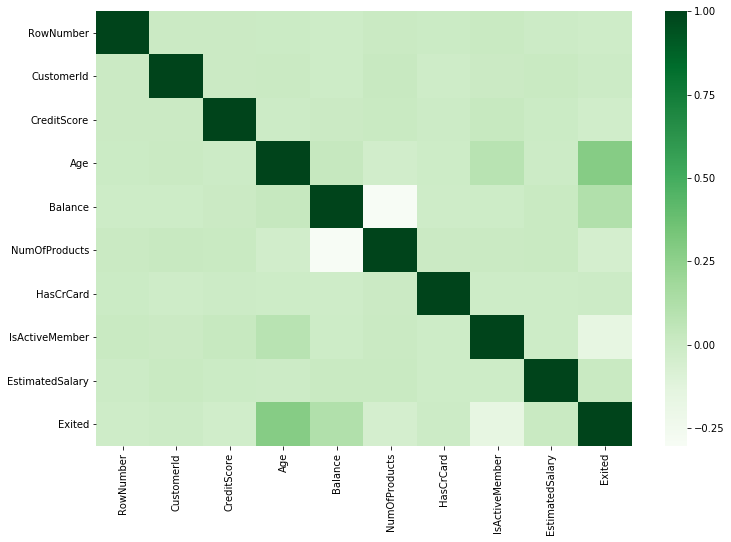

In [9]:
corr = df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Greens")

Как видно из матрицы, взаимосвязей между колонками нет, следовательно ничего не будет мешать будущей моедли

Посмотрим сколько мужчин и женщин 

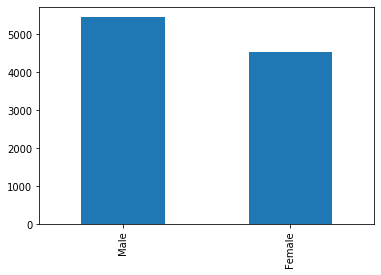

In [10]:
df['Gender'].value_counts().plot(kind='bar')

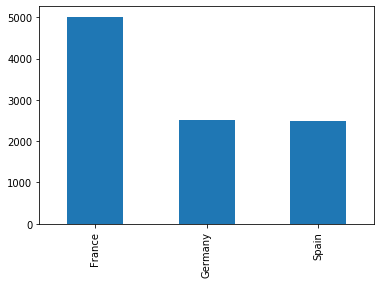

In [11]:
df['Geography'].value_counts().plot(kind='bar')

Удалим столбцы, которые не нужны будут для модели

In [12]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)

Проведем кодирование с помощью ОНЕ и стандартизируем признаки с помощью StandardScaler

In [13]:
df = pd.get_dummies(df, drop_first=True)

In [14]:
target = df['Exited']
features = df.drop('Exited', axis=1)

In [15]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify = df['Exited'])

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [16]:
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [17]:
print(features_train.shape[0])
print(features_valid.shape[0])
print(features_test.shape[0])

6000
2000
2000


**Вывод:**
Датасет состоит из 10000 объектов и 14 признаков. Из них для обучения модели не понадобятся:
- `RowNumber`
- `CustomerID`
- `Surname`

Целевой признак `Exited`, то есть нам неодходимо предсказать 1 - если клиент уйдет, 0 - если клиент останется.
В этом и заключается задача классификации. 
Кроме того:
- В датасеты представлены клиенты из трех стран: Франция ~50%, Германия ~25%, Испания ~25%
- Признак `Tenure` содержит пустые значения в количестве 909 штук
- Провели кодирование и стандартизировали признаки с помощью StandardScaler
- Мужчин в датасете чуть больше, чем женщин в соотношении ~55% на 45%
- Данные между собой не коррелируют 
- Дубликатов в датасет нет

# 2. Исследование задачи

Посмотрим как часто встречается класс 1 или 0 в целевом признаке

0    0.7963
1    0.2037
Name: Exited, dtype: float64


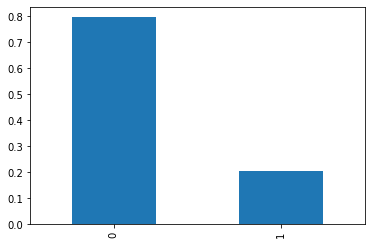

In [18]:
class_freq = df['Exited'].value_counts(normalize=True)
class_freq.plot(kind='bar')
print(class_freq)
plt.show()

Соотношение не 1:1, т.е. не сбалансированы, следовательно можно ожидвать плохие результаты 

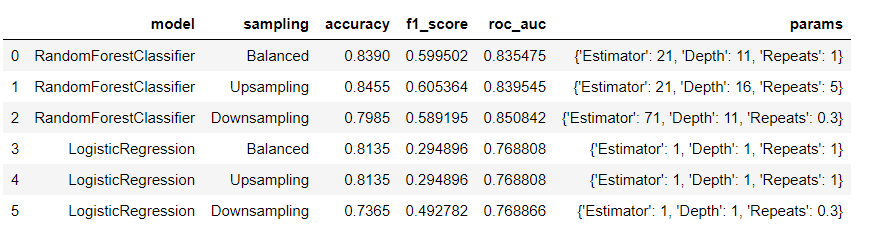

In [19]:
param = {'max_depth':[5, 10, 20, 30, 40, 50], 
         'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150], 
         'class_weight':['balanced']}
rnd_search = RandomizedSearchCV(RandomForestClassifier(), param, 
n_iter =10, cv=9)
rnd_search.fit(features_train, target_train)
rnd_search.best_params_
rnd_search.best_score_

0.8605

In [20]:
print(rnd_search.best_params_)

{'n_estimators': 80, 'max_depth': 40, 'class_weight': 'balanced'}


In [21]:
def get_scores_model(features, target, depth, estimators):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimators, class_weight='balanced')
    model.fit(features, target)
    predictions = model.predict(features_valid)
    score = accuracy_score(predictions, target_valid)
    fscore = f1_score(target_valid, predictions)

    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    roc = roc_auc_score(target_valid, probabilities_one_valid)

    print('Accuracy:', score)
    print('F1_Score is:', fscore)
    print('ROC_AUC:', roc) 

Вот так модель ведет себя с параметрами, подобранными с RandomizedSearchCV

In [22]:
get_scores_model(features_train, target_train, 30, 80)

Accuracy: 0.862
F1_Score is: 0.5533980582524272
ROC_AUC: 0.8415117012838589


А вот так с параметрами, подобранными с циклом, но правда здесь были использованы upsampling и downsampling

In [23]:
def upsampling(features, target, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [24]:
features_up, target_up = upsampling(features_train, target_train, 5)
get_scores_model(features_up, target_up, 16, 21)

Accuracy: 0.8455
F1_Score is: 0.6053639846743295
ROC_AUC: 0.8395454596030322


Посмотрим модель случайного леса со стандарными параметрами

In [25]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(predicted_valid, target_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(target_valid, predicted_valid))
confusion_matrix(target_valid, predicted_valid)

Accuracy is: 0.8585
F1_Score is: 0.5529225908372828


array([[1542,   67],
       [ 216,  175]])

Посмотрим результаты на LogisticRegression

In [26]:
# Модель logisticRegression со стандартными параметрами, посмотрим какой аккураси и f1score покажет нам модель
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(predicted_valid, target_valid)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(target_valid, predicted_valid))

confusion_matrix(target_valid, predicted_valid)

Accuracy is: 0.8135
F1_Score is: 0.2948960302457467


array([[1549,   60],
       [ 313,   78]])

Определенно результаты Случайного леса лучше, следовательно будем работать с ней и постараемся ее улучшить

# 3. Борьба с дисбалансом

Попробуем через цикл поиграть с параметрами случайного леса применив class_weight='balanced'

In [27]:
for depth,estimator in itertools.product(range(1,30,10), range(1,151,50)):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    score = accuracy_score(predictions, target_valid)
    fscore = f1_score(target_valid, predictions)
    print('Depth: {: >5.0f}       |   Estimators: {:>5.0f}'.format(depth, estimator))
    print('Accuracy: {: >5.4f}   |   F1_Score: {: >5.4f}'.format(score,fscore))
    print('------------------------------------------------------')

Depth:     1       |   Estimators:     1
Accuracy: 0.6750   |   F1_Score: 0.4792
------------------------------------------------------
Depth:     1       |   Estimators:    51
Accuracy: 0.7295   |   F1_Score: 0.4939
------------------------------------------------------
Depth:     1       |   Estimators:   101
Accuracy: 0.7510   |   F1_Score: 0.5431
------------------------------------------------------
Depth:    11       |   Estimators:     1
Accuracy: 0.7595   |   F1_Score: 0.4932
------------------------------------------------------
Depth:    11       |   Estimators:    51
Accuracy: 0.8370   |   F1_Score: 0.5852
------------------------------------------------------
Depth:    11       |   Estimators:   101
Accuracy: 0.8405   |   F1_Score: 0.5905
------------------------------------------------------
Depth:    21       |   Estimators:     1
Accuracy: 0.7845   |   F1_Score: 0.4410
------------------------------------------------------
Depth:    21       |   Estimators:    51
Accurac

Попробуем обучить нашу модель с помощью увеличения выборки

При глубине деревьев 11 и числе деревьев 51. F1_score показал наилучший результат : 0.6034 и accuracy_score : 0.8350. Попробуем улучшить показатели

Попробуем обучить нашу модель с помощью уменьшения выборки

In [28]:
def downsampling(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [29]:
columns=['model', 'sampling', 'accuracy', 'f1_score','roc_auc','params']
data = pd.DataFrame(columns=columns)

In [30]:
def train_model_for(model_name, sampling, r1,r2,r3):
    rows = []
    max_score=0
    max_fscore=0
    for repeat in np.arange(r1,r2,r3):
        if sampling == "Upsampling":
            feature_func, target_func = upsampling(features_train, target_train, repeat)
        if sampling == "Downsampling":
            feature_func, target_func = downsampling(features_train, target_train, repeat)
        if sampling == "Balanced":
            feature_func, target_func = features_train, target_train
        for depth in range(1,51,5):
            for estimator in range(1,151,10):
                if model_name == "RandomForestClassifier":
                    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=estimator, class_weight='balanced')
                if model_name == "LogisticRegression":
                    model = LogisticRegression(random_state=12345, solver='liblinear')

                model.fit(feature_func, target_func)
                predictions = model.predict(features_valid)
                score = accuracy_score(predictions, target_valid)
                fscore = f1_score(target_valid, predictions)

                probabilities_valid = model.predict_proba(features_valid)
                probabilities_one_valid = probabilities_valid[:, 1]

                roc = roc_auc_score(target_valid, probabilities_one_valid)

                if (fscore > max_fscore) and (score > max_score):
                    max_fscore = fscore
                    max_score = score
                    max_score_estimator = estimator
                    max_score_depth = depth
                    max_score_roc = roc
                    max_score_rep = repeat
                
                #print()
                #print(repeat, score, fscore, max_score, max_fscore, max_score_estimator, max_score_depth)
    
    rows.append({'model':model_name, 
                 'sampling':sampling,
                 'accuracy':max_score,
                 'f1_score':max_fscore, 
                 'roc_auc':max_score_roc,
                 'params':{'Estimator':max_score_estimator,
                           'Depth':max_score_depth,
                           'Repeats':max_score_rep}})      
    
    #print('Model:', model_name)
    #print('Accuracy:', max_score)
    #print('F1_Score is:', max_fscore)
    #print('ROC_AUC:', max_score_roc)        
    #print('Depth: {: >5.0f}       |   Estimators: {:>5.0f}'.format(max_score_depth, max_score_estimator))
    
    return rows

In [31]:
%%time
for model in ["RandomForestClassifier", "LogisticRegression"]:
    for sampling in ["Balanced", "Upsampling", "Downsampling"]:
        #print(model, sampling, end="")
        if sampling == "Balanced":
            r1,r2,r3 = 1,2,1
        if sampling == "Upsampling":
            r1,r2,r3 = 1,10,1
        if sampling == "Downsampling":
            r1,r2,r3 = 0.3, 0.31, 0.03

        result = train_model_for(model, sampling, r1,r2,r3 )
        #print(result)
        data = data.append(result, ignore_index=True)
        
        #print()

CPU times: user 26min 10s, sys: 2min 56s, total: 29min 7s
Wall time: 29min 28s


In [32]:
data

,model,sampling,accuracy,f1_score,roc_auc,params
0,RandomForestClassifier,Balanced,0.8390,0.599502,0.835475,"{'Estimator': 21, 'Depth': 11, 'Repeats': 1}"
1,RandomForestClassifier,Upsampling,0.8455,0.605364,0.839545,"{'Estimator': 21, 'Depth': 16, 'Repeats': 5}"
2,RandomForestClassifier,Downsampling,0.7985,0.589195,0.850842,"{'Estimator': 71, 'Depth': 11, 'Repeats': 0.3}"
3,LogisticRegression,Balanced,0.8135,0.294896,0.768808,"{'Estimator': 1, 'Depth': 1, 'Repeats': 1}"
4,LogisticRegression,Upsampling,0.8135,0.294896,0.768808,"{'Estimator': 1, 'Depth': 1, 'Repeats': 1}"
5,LogisticRegression,Downsampling,0.7365,0.492782,0.768866,"{'Estimator': 1, 'Depth': 1, 'Repeats': 0.3}"


**Вывод:**
- Через цикл попробовали методом подбора количества деревьев и глубины леса подобрать нужные параметры. Выявили лучшие параметры это: глубина : 16, количество деревьев 21. F1 score показал 0.6053
- Попробовали улучшить модели путем увеличения и уменьшения выборок но увеличить f1_score не удалось.

# 4. Тестирование модели

На основе наших экспериментов с моделями можем сделать вывод, что лучшей моделью является случайный лес с количеством деревьев равным 51 и глубиной равной 11 с учетом балансировки классов.

In [33]:
features_up, target_up = upsampling(features_train, target_train, 5)
get_scores_model(features_up, target_up, 16, 21)

Accuracy: 0.8455
F1_Score is: 0.6053639846743295
ROC_AUC: 0.8395454596030322


In [34]:
model = RandomForestClassifier(n_estimators = 51, max_depth=11, class_weight='balanced', random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)

accuracy_valid = accuracy_score(predicted_valid, target_test)
print('Accuracy is:', accuracy_valid)
print('F1_Score is:', f1_score(target_test, predicted_valid))

Accuracy is: 0.85
F1_Score is: 0.6376811594202898


Посчитаем AUC-ROC для нашей модели и посмотрим насколько она лучше случайной модели:

In [35]:
!pip install plot_metric

Defaulting to user installation because normal site-packages is not writeable


In [36]:
from plot_metric.functions import BinaryClassification

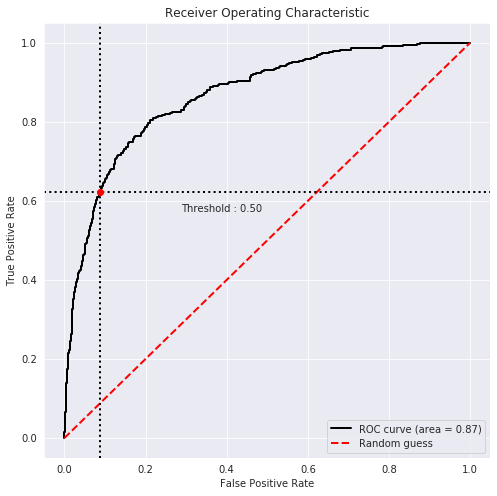

Roc Auc Score is: 0.867




In [37]:
target_pred = model.predict_proba(features_test)[:,1]
bc = BinaryClassification(target_test, target_pred, labels=["Class 1"])

plt.figure(figsize=(8,8))
bc.plot_roc_curve()
plt.show()
print('Roc Auc Score is: {:.3f}'.format(roc_auc_score(target_test, target_pred)))
print('\n')

**Общий вывод:**
- Подготовили датасет для прогнозирования оттока клиентов
- Использовали две модели : RandomForestClassifier и LogisticRegression, на начальном этапе LogisticRegression показал наихудшие результаты, поэтому мы выбрали RandomForestClassifier для дальнейшей работы.
- Попробовали увеличить и уменьшить выборки для увеличения f1_score, но наибольшее, что мы получили это f1_score : 0.56. Впринципе, требоваемое задание выполнили, но применив метод подбора количества деревьев и глубины леса через цикл мы нашли наилучшие параметры для Случайного Леса и получили F1_score : 0.62
- roc auc score : 85, что значительно больше случайного порога в 0.5. Наша модель предсказывает достаточно хорошо.